In [ ]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet, sliding_window
import torch
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn

In [20]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=1
inChannels=1
terminal_show_freq=50
model='VNET'
opt='sgd'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}

save = ('../saved_models/' + model + '_checkpoints/' + model + '_', dataset_name)[0]

In [3]:
# MAKE REPRODUCIBLE
torch.manual_seed(42)
np.random.seed(42)
cudnn.deterministic = True
# FOR FASTER GPU TRAINING WHEN INPUT SIZE DOESN'T VARY
# LET'S TEST IT
cudnn.benchmark = True

# Test data loading

In [5]:
# dataset training
dataset_train = SegmentationDataSet(inputs=['test_cube.fits'],
                                    targets=['test_seg.fits'],
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=True,
                                    root='./',
                                    mode="train")

## What the data should look like

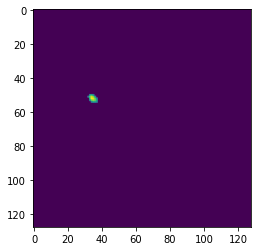

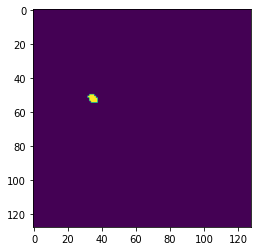

In [8]:
getdata = dataset_train.__getitem__(10)
view_x, view_y = getdata[0].squeeze().numpy(), getdata[1].squeeze().numpy()
plt.imshow(view_x[:, :, 20])
plt.show()
plt.imshow(view_y[:, :, 20])
plt.show()

## Loading like the training data was loaded

In [21]:
# dataloader training
params = {'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 2}
dataloader_training = DataLoader(dataset=dataset_train, **params)
for i, img_tensor in enumerate(dataloader_training):
    if i == 11:
        data_loader_tensor = img_tensor[0]
        data_loader_mask = img_tensor[1]
data_loader_mask.shape

torch.Size([1, 1, 128, 128, 64])

## Taking just first slice of both extra dimensions

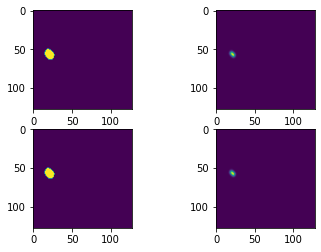

In [185]:
fig, axes = plt.subplots(2, 2)
axes[0][0].imshow(data_loader_mask.view(1, 128, 128, 64).squeeze()[..., 20])
axes[1][0].imshow(data_loader_mask.view(1, 128, 128, 64).squeeze()[..., 20])
axes[0][1].imshow(data_loader_tensor[0][0][..., 20])
axes[1][1].imshow(data_loader_tensor[0][0][..., 20])

## Load pre-trained model

In [194]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=1
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = '../inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 1, "../saved_models/VNET_checkpoints/VNET_/VNET__last_epoch.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45599926


2

In [182]:
model.eval()
with torch.no_grad():
    out = model.inference(data_loader_tensor)
full_vol_prediction = out.view(1, 128, 128, 64)
_, indices = full_vol_prediction.max(dim=0)

In [183]:
out_softmax = torch.softmax(out, dim=1)

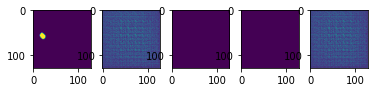

In [184]:
fig, axes = plt.subplots(1, 5)
axes[0].imshow(data_loader_mask.squeeze()[..., 20])
axes[1].imshow(out.squeeze()[..., 20])
axes[2].imshow(out_softmax.squeeze()[..., 20])
axes[3].imshow(indices[..., 20])
axes[4].imshow(_[..., 20])

# Resave better data

In [144]:
cube_hdulist = fits.open("../data/training/Input/noisefree_1245mosC.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()

maskcube_hdulist = fits.open("../data/training/Target/mask_1245mosC.fits")
maskcube_data = maskcube_hdulist[0].data
maskcube_hdulist.close()

In [164]:
list_z = np.linspace(0, maskcube_data.shape[0], 6)
list_x = np.linspace(0, maskcube_data.shape[1], 6)
list_y = np.linspace(0, maskcube_data.shape[2], 6)

In [173]:
! ls ../Input

noisefree_0.fits noisefree_2.fits noisefree_4.fits
noisefree_1.fits noisefree_3.fits


In [172]:
for i in range(5):
    new_mask = maskcube_data[int(list_z[i]):int(list_z[i+1]), int(list_x[i]):int(list_x[i+1]), int(list_y[i]):int(list_y[i+1])]
    fits.writeto('../Input/noisefree_%s.fits'%i, new_mask, cube_hdulist[0].header, overwrite=True)
    new_cube = cube_data[int(list_z[i]):int(list_z[i+1]), int(list_x[i]):int(list_x[i+1]), int(list_y[i]):int(list_y[i+1])]
    fits.writeto('../Target/mask_%s.fits'%i, new_cube, cube_hdulist[0].header, overwrite=True)
    
    

## Training Metrics

In [ ]:
df = pd.DataFrame([["train", 1, 0.9984, 0.1560, 0.0016],
["val", 1, 0.9835, 1.6542, 0.0165],
["train", 2, 0.9984, 0.1560, 0.0016],
["val", 2, 0.9834, 1.6566, 0.0166],
["train", 3, 0.9984, 0.1560, 0.0016],
["val", 3, 0.9834, 1.6583, 0.0166],
["train", 4, 0.9984, 0.1558, 0.0016],
["val", 4, 0.9834, 1.6643, 0.0166]],
            columns=["test_train", "Epoch", "Loss", "DSC", "gal"])
df

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2) 
ax1.plot(df[df.test_train == "train"].Epoch, df[df.test_train == "train"].Loss)
ax2.plot(df[df.test_train == "val"].Epoch, df[df.test_train == "val"].Loss)

ax3.plot(df[df.test_train == "train"].Epoch, df[df.test_train == "train"].DSC)
ax4.plot(df[df.test_train == "val"].Epoch, df[df.test_train == "val"].DSC)
ax3.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax3.set_ylabel("DCD")
fig.tight_layout()